# Tesla Stock Predictor

This project deals with web scraping Tesla stock prices from the Yahoo Finance page, using Beautiful Soup and Selenium, and using Recurrent Neural Networks (particularly LSTMs) to build a Deep Learning model to predict future stock prices.

In [91]:
import os 
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib
import pandas as pd
from datetime import datetime
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX, STLForecast
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [92]:
df=pd.read_csv('tsla.csv')
df


,Unnamed: 0,Date,Open,High,Low,Close*,Adj Close**,Volume
0,0,"Apr 29, 2020",790.17,803.20,783.16,800.51,800.51,15812100
1,1,"Apr 28, 2020",795.64,805.00,756.69,769.12,769.12,15222000
2,2,"Apr 27, 2020",737.61,799.49,735.00,798.75,798.75,20681400
3,3,"Apr 24, 2020",710.81,730.73,698.18,725.15,725.15,13237600
4,4,"Apr 23, 2020",727.60,734.00,703.13,705.63,705.63,13236700
...,...,...,...,...,...,...,...,...
248,248,"May 06, 2019",250.02,258.35,248.50,255.34,255.34,10833900
249,249,"May 03, 2019",243.86,256.61,243.49,255.03,255.03,23706800
250,250,"May 02, 2019",245.52,247.13,237.72,244.10,244.10,18159300
251,251,"May 01, 2019",238.85,240.00,231.50,234.01,234.01,10704400


Creating a function to plot Time Series Data:

In [93]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


There’s a year’s worth of stock prices here, from April 30, 2019 to April 29, 2020, with a few days’ data missing.

But first, there is some Data Cleaning that needs to be done:

The columns “Close” and “Adj Close” have additional * symbols which have to be removed:

In [94]:
df.drop(labels="Unnamed: 0", axis=1, inplace=True)
df.rename(columns={"Close*": "Close", "Adj Close**": "Adj Close"},inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Apr 29, 2020",790.17,803.20,783.16,800.51,800.51,15812100
1,"Apr 28, 2020",795.64,805.00,756.69,769.12,769.12,15222000
2,"Apr 27, 2020",737.61,799.49,735.00,798.75,798.75,20681400
3,"Apr 24, 2020",710.81,730.73,698.18,725.15,725.15,13237600
4,"Apr 23, 2020",727.60,734.00,703.13,705.63,705.63,13236700
...,...,...,...,...,...,...,...
248,"May 06, 2019",250.02,258.35,248.50,255.34,255.34,10833900
249,"May 03, 2019",243.86,256.61,243.49,255.03,255.03,23706800
250,"May 02, 2019",245.52,247.13,237.72,244.10,244.10,18159300
251,"May 01, 2019",238.85,240.00,231.50,234.01,234.01,10704400


Next, it would be much easier if the order of the data was reversed, since the data was originally arranged as latest to earliest.

This would make it easier to use the earlier data for training and the later data for validation/testing.

In [95]:
df=pd.DataFrame(df.values[::-1], df.index, df.columns)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Apr 30, 2019",242.06,244.21,237.0,238.69,238.69,9464600
1,"May 01, 2019",238.85,240.0,231.5,234.01,234.01,10704400
2,"May 02, 2019",245.52,247.13,237.72,244.1,244.1,18159300
3,"May 03, 2019",243.86,256.61,243.49,255.03,255.03,23706800
4,"May 06, 2019",250.02,258.35,248.5,255.34,255.34,10833900
...,...,...,...,...,...,...,...
248,"Apr 23, 2020",727.6,734.0,703.13,705.63,705.63,13236700
249,"Apr 24, 2020",710.81,730.73,698.18,725.15,725.15,13237600
250,"Apr 27, 2020",737.61,799.49,735.0,798.75,798.75,20681400
251,"Apr 28, 2020",795.64,805.0,756.69,769.12,769.12,15222000


Creating a seperate Data Frame to visualize the stock prices better:

In [96]:
adj_close=df['Adj Close']
adj_close.index = df['Date']

adj_close.head()

Date
Apr 30, 2019    238.69
May 01, 2019    234.01
May 02, 2019     244.1
May 03, 2019    255.03
May 06, 2019    255.34
Name: Adj Close, dtype: object

The “Date” column in the original Data Frame is of type “String”, but it has to be of “Datetime” format, to make it easier to plot it in the x-axis.

In [97]:
dates=df['Date']
dates1=[]
for date in dates:
    dates1.append(datetime.strptime(date, '%b %d, %Y'))
dates=pd.core.series.Series(dates1)

Plotting the Adjusted Close Stock Prices over the last year:

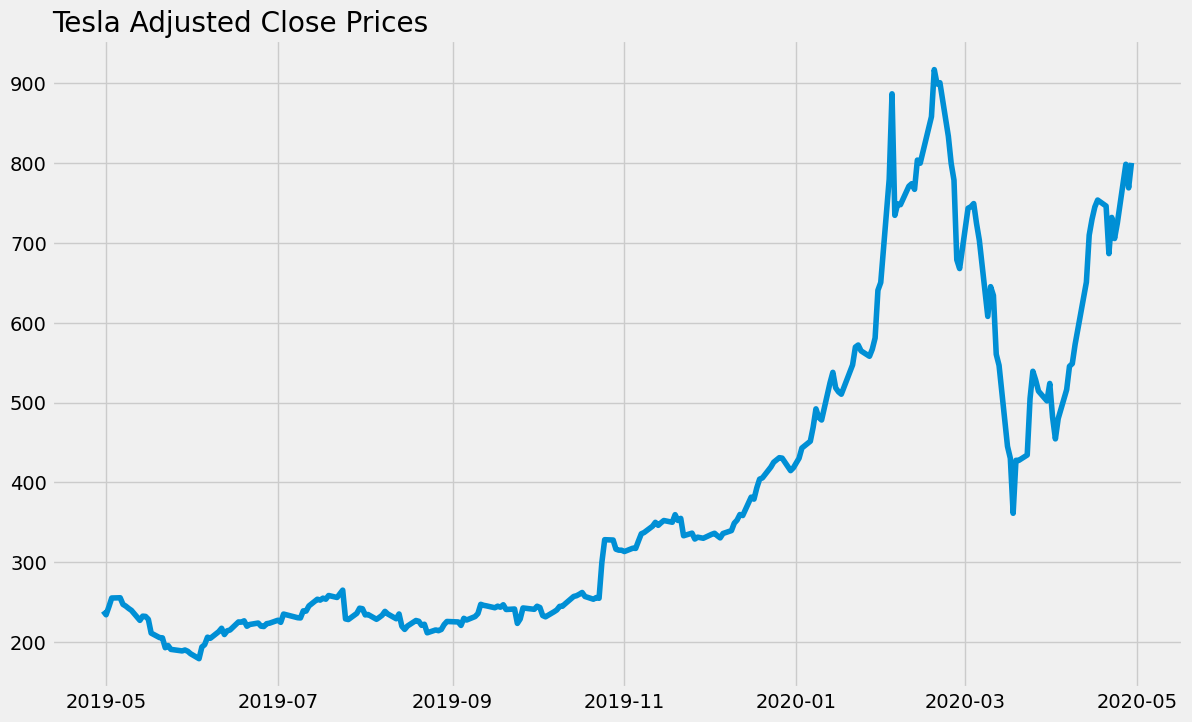

In [98]:
plt.figure(figsize=(13,8))
plt.style.use('fivethirtyeight')
plt.plot(dates1,adj_close)
plt.title("Tesla Adjusted Close Prices",loc='left')
plt.rcParams.update({'font.size': 14})

There’s a huge up-tick in the price sometime after January 2020, which was when Tesla announced strong fourth-quarter financials, which exceeded all expectations.
The dip in the price in March corresponds to the COVID-19 pandemic and the financial crisis that it brought with it.

It does seem to be on the rise now, so it will be interesting to see if the model can predict all these ups and downs.

Creating Series and Time arrays, and converting them to the right type:

In [99]:
series = np.array(adj_close.values)
time = np.array(dates)

In [100]:
series=pd.to_numeric(series,errors='coerce',downcast='float')
series

array([238.69, 234.01, 244.1 , 255.03, 255.34, 247.06, 244.84, 241.98,
       239.52, 227.01, 232.31, 231.95, 228.33, 211.03, 205.36, 205.08,
       192.73, 195.49, 190.63, 188.7 , 189.86, 188.22, 185.16, 178.97,
       193.6 , 196.59, 205.95, 204.5 , 212.88, 217.1 , 209.26, 213.91,
       214.92, 225.03, 224.74, 226.43, 219.62, 221.86, 223.64, 219.76,
       219.27, 222.84, 223.46, 227.17, 224.55, 234.9 , 233.1 , 230.34,
       230.06, 238.92, 238.6 , 245.08, 253.5 , 252.38, 254.86, 253.54,
       258.18, 255.68, 260.17, 264.88, 228.82, 228.04, 235.77, 242.26,
       241.61, 233.85, 234.34, 228.32, 230.75, 233.42, 238.3 , 235.01,
       229.01, 235.  , 219.62, 215.64, 219.94, 226.83, 225.86, 220.83,
       222.15, 211.4 , 215.  , 214.08, 215.59, 221.71, 225.61, 225.01,
       220.68, 229.58, 227.45, 231.79, 235.54, 247.1 , 245.87, 245.2 ,
       242.81, 244.79, 243.49, 246.6 , 240.62, 241.23, 223.21, 228.7 ,
       242.56, 242.13, 240.87, 244.69, 243.13, 233.03, 231.43, 237.72,
      

In [101]:
series.dtype

dtype('float32')

There are about 250 tuples, so a 80-20 split is somewhere around 210 for training set and 40 for testing set. The window size (for creating a windowed_dataset) and batch size can also be specified here.

In [102]:
split_time = 210
adj_train = series[:split_time]
adj_valid = series[split_time:]
dates_train=dates[:split_time]
dates_valid=dates[split_time:]

window_size = 16
batch_size = 32
shuffle_buffer_size = 50

In [103]:
adj_train=pd.to_numeric(adj_train,errors='coerce',downcast='float')
adj_train.astype(float)
adj_train

series[...,np.newaxis]

array([[238.69],
       [234.01],
       [244.1 ],
       [255.03],
       [255.34],
       [247.06],
       [244.84],
       [241.98],
       [239.52],
       [227.01],
       [232.31],
       [231.95],
       [228.33],
       [211.03],
       [205.36],
       [205.08],
       [192.73],
       [195.49],
       [190.63],
       [188.7 ],
       [189.86],
       [188.22],
       [185.16],
       [178.97],
       [193.6 ],
       [196.59],
       [205.95],
       [204.5 ],
       [212.88],
       [217.1 ],
       [209.26],
       [213.91],
       [214.92],
       [225.03],
       [224.74],
       [226.43],
       [219.62],
       [221.86],
       [223.64],
       [219.76],
       [219.27],
       [222.84],
       [223.46],
       [227.17],
       [224.55],
       [234.9 ],
       [233.1 ],
       [230.34],
       [230.06],
       [238.92],
       [238.6 ],
       [245.08],
       [253.5 ],
       [252.38],
       [254.86],
       [253.54],
       [258.18],
       [255.68],
       [260.17


A function for creating a windowed dataset can be specified here. This is particularly helpful because it helps to create specific sized data slices, to train on them, make predictions, and subsequently learn from those predictions as well.

In [104]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

A function for forecasting data, given the series and the model can be specified here:

In [105]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


Creating our windowed training set:

In [106]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(adj_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(adj_train.shape)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>
(210,)


Specifying the layers of our Keras model.

It has 1 Convolutional Layer, which complements the windowing of the dataset. Simply through extensive trial and error, the configuration of 2 LSTMs (64 and 32 nodes), and 3 Dense Layers (24, 12 and 1 nodes) was selected here.

In [107]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(24, activation="relu"),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

Before actually running our model in its entirity, it might help to specify a learning rate, so the model can be run for a specified number of epochs, and seeing how the model does, a optimized learning rate can be found. This hyperparameter tuning will prove to be very useful later.

In [108]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 238.5573 - mae: 239.0573 - lr: 1.0000e-08
Epoch 2/100
1/1 [==============================] - 0s 69ms/step - loss: 238.5193 - mae: 239.0193 - lr: 1.1220e-08
Epoch 3/100
1/1 [==============================] - 0s 89ms/step - loss: 238.4422 - mae: 238.9422 - lr: 1.2589e-08
Epoch 4/100
1/1 [==============================] - 0s 85ms/step - loss: 238.3240 - mae: 238.8240 - lr: 1.4125e-08
Epoch 5/100
1/1 [==============================] - 0s 85ms/step - loss: 238.1618 - mae: 238.6618 - lr: 1.5849e-08
Epoch 6/100
1/1 [==============================] - 0s 88ms/step - loss: 237.9516 - mae: 238.4516 - lr: 1.7783e-08
Epoch 7/100
1/1 [==============================] - 0s 88ms/step - loss: 237.6888 - mae: 238.1888 - lr: 1.9953e-08
Epoch 8/100
1/1 [==============================] - 0s 88ms/step - loss: 237.3678 - mae: 237.8678 - lr: 2.2387e-08
Epoch 9/100
1/1 [==============================] - 0s 92ms/step - loss: 236.9815 - mae: 23

Plotting the results of the limited run of the model:

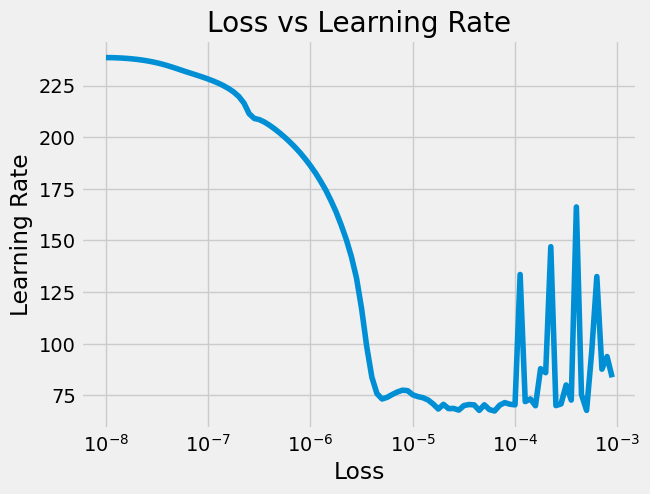

In [109]:
plt.title("Loss vs Learning Rate")
plt.xlabel("Loss")
plt.ylabel("Learning Rate")
plt.semilogx(history.history["lr"], history.history["loss"])

There’s a huge dip in the learning rate somewhere between $10^-7$ and $10^-6$, which helps the gradient descent process in training, helping the model to learn quickly and more effectively, so that can be fixed as the learning rate, and the model is run completely this time:

In [110]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 500)
])



optimizer = tf.keras.optimizers.SGD(lr=3e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=350)

Epoch 1/350
1/1 [==============================] - 2s 2s/step - loss: 177.2301 - mae: 177.7301
Epoch 2/350
1/1 [==============================] - 0s 223ms/step - loss: 295656.7500 - mae: 295657.2188
Epoch 3/350
1/1 [==============================] - 0s 233ms/step - loss: 465185.0938 - mae: 465185.5312
Epoch 4/350
1/1 [==============================] - 0s 233ms/step - loss: 601092352.0000 - mae: 601092352.0000
Epoch 5/350
1/1 [==============================] - 0s 268ms/step - loss: 116532218691584.0000 - mae: 116532218691584.0000
Epoch 6/350
1/1 [==============================] - 0s 268ms/step - loss: 10633644313935872.0000 - mae: 10633644313935872.0000
Epoch 7/350
1/1 [==============================] - 0s 276ms/step - loss: 716826944.0000 - mae: 716826944.0000
Epoch 8/350
1/1 [==============================] - 0s 277ms/step - loss: 282552146262155591680.0000 - mae: 282552146262155591680.0000
Epoch 9/350
1/1 [==============================] - 0s 274ms/step - loss: 2690.6982 - mae: 2691.

The MAE (Mean Absolute Error) seems pretty low after running it for 350 epochs, which is an excellent sign. It started at ~330 and ended around ~19. Now we can build a forecast using the model_forecast function specified earlier:

In [111]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1, 0]

6/6 [==============================] - 1s 75ms/step


There are mainly 2 metrics used for evaluating the accuracy of time series data, Mean Absolute Error and Root Mean Squared Error.

In [112]:
n = tf.keras.metrics.MeanAbsoluteError()
n.update_state(adj_valid, rnn_forecast)
print('Mean Absolute Error: ', n.result().numpy())
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(adj_valid, rnn_forecast)
print('Root Mean Squared Error: ', m.result().numpy())

Mean Absolute Error:  5858.9214
Root Mean Squared Error:  5860.2275


Considering the fact that there was only 250 data points, and a pretty simple RNN built, a MAE of 150 and RMSE of 171 is extremely good. With more data, and a bigger model, it’s very possible to reduce these numbers.

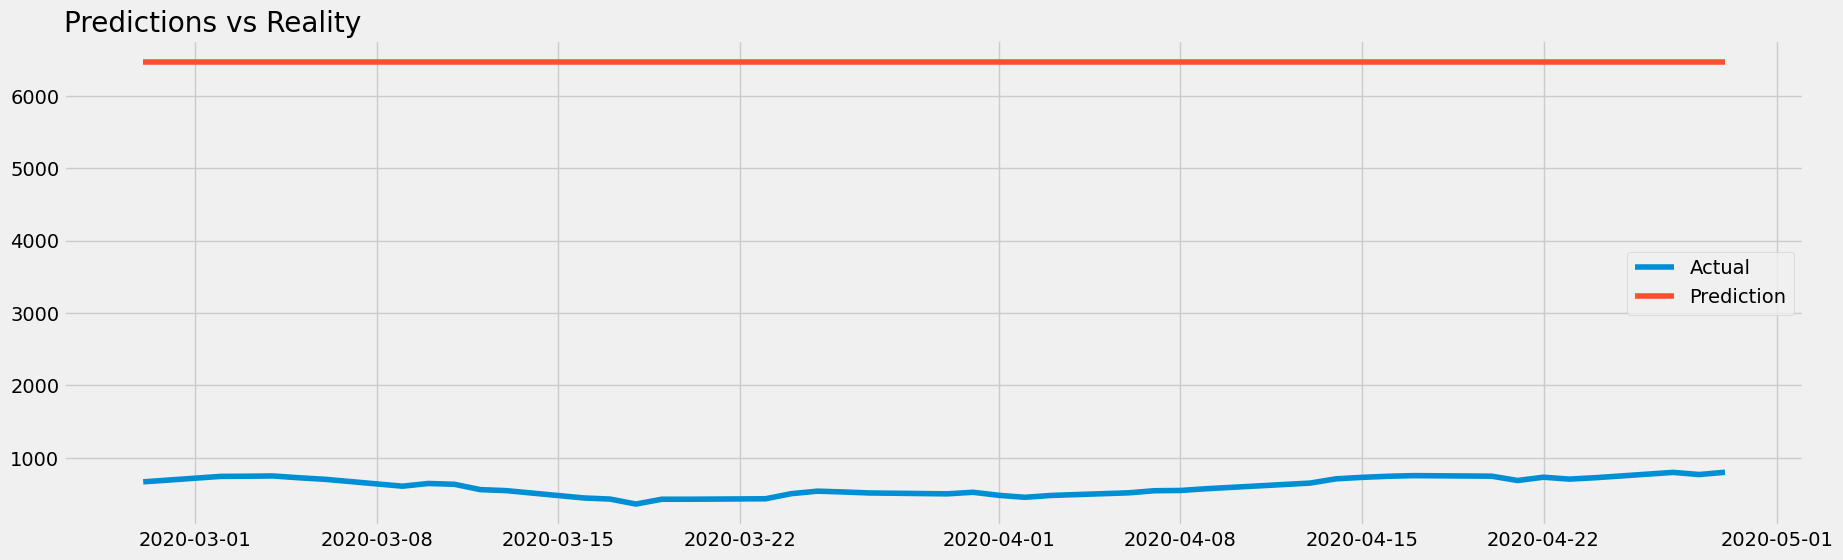

In [113]:
plt.figure(figsize=(20, 6))
plt.style.use('fivethirtyeight')
plt.title("Predictions vs Reality", loc="left")
plt.plot(dates_valid, adj_valid, label="Actual")
plt.plot(dates_valid, rnn_forecast, label= "Prediction")
plt.legend()

The model seemed to have gotten it pretty spot-on. It dips when the actual value dipped and seems to be on the rise, as is the case towards the end.

In [116]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Define train and validation sizes
train_size = 80
validation_size = 20

train, validation = series[:train_size], series[train_size:]

# Grid search for optimal parameters
seasonal_periods = [7, 12]  # Define the list of possible seasonal periods
trend_components = ["add", "mul", None]
seasonal_components = ["add", "mul", None]
lowest_mse = float("inf")
best_params = ()

for seasonal_period in seasonal_periods:
    for trend in trend_components:
        for seasonal in seasonal_components:
            try:
                model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=validation_size)
                mse = mean_squared_error(validation, forecast)

                if mse < lowest_mse:
                    lowest_mse = mse
                    best_params = (trend, seasonal, seasonal_period)
            except:
                continue

if best_params:
    print(f"Best parameters: trend={best_params[0]}, seasonal={best_params[1]}, seasonal_periods={best_params[2]}")
    print(f"Lowest MSE: {lowest_mse}")

    # Train and forecast with the optimal parameters
    optimal_model = ExponentialSmoothing(train, trend=best_params[0], seasonal=best_params[1], seasonal_periods=best_params[2])
    optimal_model_fit = optimal_model.fit()
    optimal_forecast = optimal_model_fit.forecast(steps=validation_size)

    print(f"Validation MSE: {mean_squared_error(validation, optimal_forecast)}")
else:
    print("No suitable parameters found.")


/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


No suitable parameters found.


/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [118]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Define train and validation sizes
train_size = 80
validation_size = 20

train, validation = series[:train_size], series[train_size:]

# Grid search for optimal parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

lowest_mse = float("inf")
best_params = ()

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=validation_size)
                mse = mean_squared_error(validation, forecast)

                if mse < lowest_mse:
                    lowest_mse = mse
                    best_params = (p, d, q)
            except:
                continue

if best_params:
    print(f"Best parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}")
    print(f"Lowest MSE: {lowest_mse}")

    # Train and forecast with the optimal parameters
    optimal_model = ARIMA(train, order=best_params)
    optimal_model_fit = optimal_model.fit()
    optimal_forecast = optimal_model_fit.forecast(steps=validation_size)

    print(f"Validation MSE: {mean_squared_error(validation, optimal_forecast)}")
else:
    print("No suitable parameters found.")


/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum L

No suitable parameters found.


/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kaaneyvaz/miniconda3/envs/myenv2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import numpy as np
import pandas as pd
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Define train and validation sizes
train_size = 80
validation_size = 20

train, validation = series[:train_size], series[train_size:]

# Grid search for optimal parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p_values, d_values, q_values))]

lowest_mse = float("inf")
best_params = ()

for param in seasonal_pdq:
    try:
        model = SARIMAX(train, order=(param[0], param[1], param[2]), seasonal_order=(param[0], param[1], param[2], param[3]))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=validation_size)
        mse = mean_squared_error(validation, forecast)

        if mse < lowest_mse:
            lowest_mse = mse
            best_params = param
    except:
        continue

if best_params:
    print(f"Best parameters: PDQ={best_params[0], best_params[1], best_params[2]}, Seasonal PDQ={best_params}")
    print(f"Lowest MSE: {lowest_mse}")

    # Train and forecast with the optimal parameters
    optimal_model = SARIMAX(train, order=(best_params[0], best_params[1], best_params[2]), seasonal_order=best_params)
    optimal_model_fit = optimal_model.fit()
    optimal_forecast = optimal_model_fit.forecast(steps=validation_size)

    print(f"Validation MSE: {mean_squared_error(validation, optimal_forecast)}")
else:
    print("No suitable parameters found.")


In [132]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define train and validation sizes
train_size = 80
validation_size = 20

train, validation = series[:train_size], series[train_size:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
validation_scaled = scaler.transform(validation.reshape(-1, 1))

# Prepare data for LSTM
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
X_train, y_train = create_dataset(train_scaled, look_back)
X_validation, y_validation = create_dataset(validation_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

# Grid search for optimal parameters
batch_sizes = [1, 5, 10]
epochs = [10, 50, 100]
lowest_mse = float("inf")
best_params = ()

for batch_size in batch_sizes:
    for epoch in epochs:
        # Create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(4, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss="mean_squared_error", optimizer="adam")
        model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)

        # Make predictions
        train_predict = model.predict(X_train)
        validation_predict = model.predict(X_validation)

        # Invert predictions
        train_predict = scaler.inverse_transform(train_predict)
        y_train_inverse = scaler.inverse_transform([y_train])
        validation_predict = scaler.inverse_transform(validation_predict)
        y_validation_inverse = scaler.inverse_transform([y_validation])

        # Calculate mean squared error
        train_mse = mean_squared_error(y_train_inverse[0], train_predict[:, 0])
        validation_mse = mean_squared_error(y_validation_inverse[0], validation_predict[:, 0])

        if validation_mse < lowest_mse:
            lowest_mse = validation_mse
            best_params = (batch_size, epoch)

print(f"Best parameters: Batch size={best_params[0]}, Epochs={best_params[1]}")
print(f"Lowest validation MSE: {lowest_mse}")


6/6 [==============================] - 0s 542us/step
Best parameters: Batch size=5, Epochs=100
Lowest validation MSE: 32493.729201857102


In [125]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

def create_dataset(data, window_size=1):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

# Find the optimal window size
min_mse = float("inf")
optimal_window_size = None
window_sizes = list(range(1, 21))

tscv = TimeSeriesSplit(n_splits=5)
for window_size in window_sizes:
    mse = 0
    for train_index, test_index in tscv.split(series):
        train, validation = series[train_index], series[test_index]

        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled = scaler.fit_transform(train.reshape(-1, 1))
        validation_scaled = scaler.transform(validation.reshape(-1, 1))

        X_train, y_train = create_dataset(train_scaled, window_size)
        X_validation, y_validation = create_dataset(validation_scaled, window_size)

        mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
        mlp.fit(X_train, y_train)

        predictions = mlp.predict(X_validation)
        mse += mean_squared_error(y_validation, predictions)

    mse /= 5
    if mse < min_mse:
        min_mse = mse
        optimal_window_size = window_size

print(f"Optimal window size: {optimal_window_size}")

# Train MLP with the optimal window size
train_size = int(len(series) * 0.8)
train, validation = series[:train_size], series[train_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
validation_scaled = scaler.transform(validation.reshape(-1, 1))

X_train, y_train = create_dataset(train_scaled, optimal_window_size)
X_validation, y_validation = create_dataset(validation_scaled, optimal_window_size)

mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

mlp_predictions = mlp.predict(X_validation)
print("MLP predictions on the validation set:")
print(mlp_predictions)

mse = mean_squared_error(y_validation, mlp_predictions)
print(f"Mean squared error for MLP Regressor: {mse}")


Optimal window size: 6
MLP predictions on the validation set:
[0.99866915 0.99474955 0.92245495 0.87892425 0.8740666  0.9048325
 0.9133358  0.83688414 0.80994546 0.77786994 0.75204635 0.75349784
 0.7138736  0.6478472  0.52338123 0.48171118 0.41293004 0.40383187
 0.43458268 0.4180695  0.4477043  0.45981118 0.511338   0.48917934
 0.47098997 0.50729513 0.5120033  0.47317073 0.4538069  0.48714605
 0.54274166 0.543167   0.5448772  0.60746574 0.7023934  0.7707685
 0.7889682  0.8042655  0.8412515  0.8316642  0.83438504 0.838724
 0.8638693  0.8917228  0.89359033]
Mean squared error for MLP Regressor: 0.014222295954823494


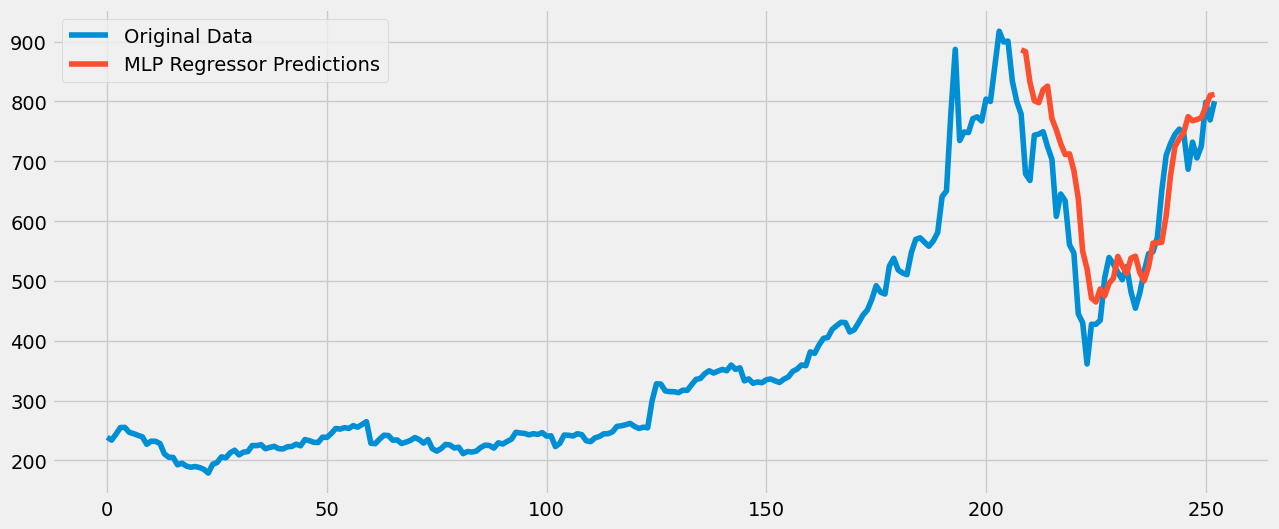

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Get the unscaled predictions
mlp_unscaled_predictions = scaler.inverse_transform(mlp_predictions.reshape(-1, 1))

# Create a new array with the same length as the original data
full_predictions = np.empty_like(series)
full_predictions[:] = np.nan

# Fill the new array with the predicted values starting from the first validation index
full_predictions[train_size + optimal_window_size:] = mlp_unscaled_predictions.reshape(-1)

# Plot the original data and the predictions
plt.figure(figsize=(14, 6))
plt.plot(series, label='Original Data')
plt.plot(full_predictions, label='MLP Regressor Predictions')
plt.legend()
plt.show()


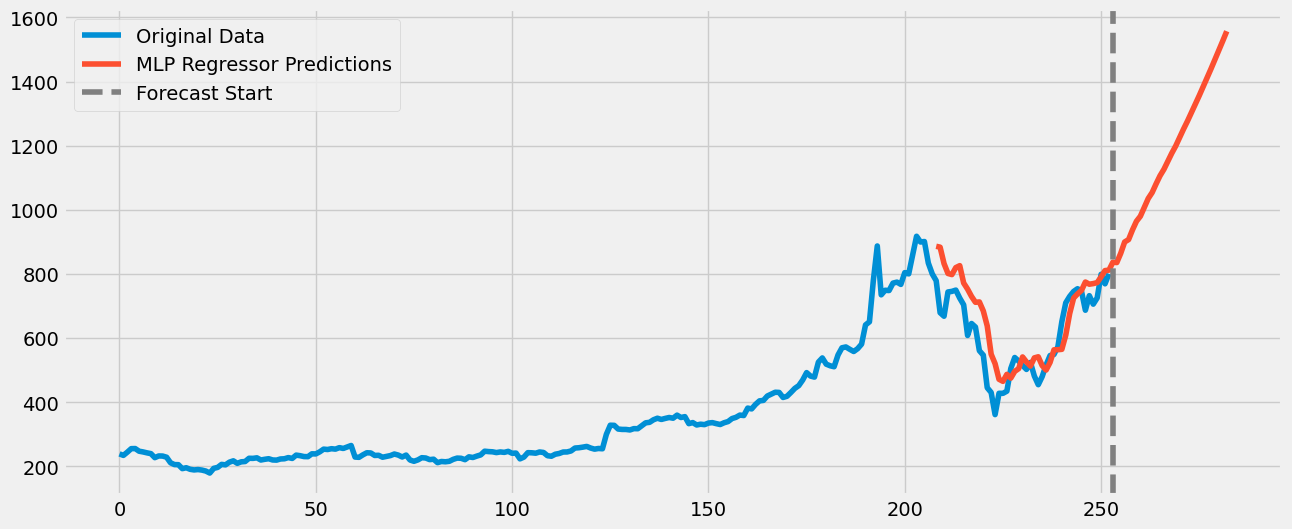

In [130]:
forecast_steps = 30

# Create a new array with the same length as the original data plus the forecast steps
extended_series_length = len(series) + forecast_steps
full_predictions = np.empty((extended_series_length, 1))
full_predictions[:] = np.nan

# Fill the new array with the predicted values starting from the first validation index
full_predictions[train_size + optimal_window_size:train_size + len(mlp_unscaled_predictions) + optimal_window_size] = mlp_unscaled_predictions.reshape(-1, 1)

# Forecast future steps
future_X = np.vstack((train_scaled[-optimal_window_size:], validation_scaled[-optimal_window_size:]))

for i in range(forecast_steps):
    future_X_scaled = future_X[-optimal_window_size:].reshape(1, -1)
    future_prediction = mlp.predict(future_X_scaled)
    future_prediction_unscaled = scaler.inverse_transform(future_prediction.reshape(-1, 1))
    full_predictions[len(series) + i] = future_prediction_unscaled
    future_X = np.vstack((future_X, future_prediction))

# Plot the original data and the predictions
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(series)), series, label='Original Data')
plt.plot(np.arange(extended_series_length), full_predictions, label='MLP Regressor Predictions')
plt.axvline(x=len(series), linestyle='--', color='gray', label='Forecast Start')
plt.legend()
plt.show()
